               グラフloss          %
Id                   0   0.000000
MSSubClass           0   0.000000
MSZoning             0   0.000000
LotFrontage        259  17.764060
LotArea              0   0.000000
Street               0   0.000000
Alley                0   0.000000
LotShape             0   0.000000
LandContour          0   0.000000
Utilities            0   0.000000
LotConfig            0   0.000000
LandSlope            0   0.000000
Neighborhood         0   0.000000
Condition1           0   0.000000
Condition2           0   0.000000
BldgType             0   0.000000
HouseStyle           0   0.000000
OverallQual          0   0.000000
OverallCond          0   0.000000
YearBuilt            0   0.000000
YearRemodAdd         0   0.000000
RoofStyle            0   0.000000
RoofMatl             0   0.000000
Exterior1st          0   0.000000
Exterior2nd          0   0.000000
MasVnrType           0   0.000000
MasVnrArea           8   0.548697
ExterQual            0   0.000000
ExterCond     

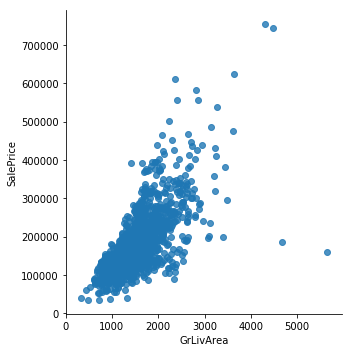

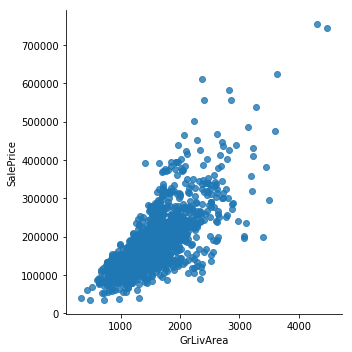

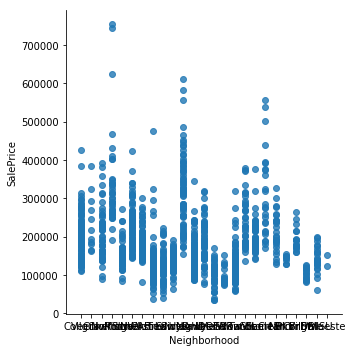

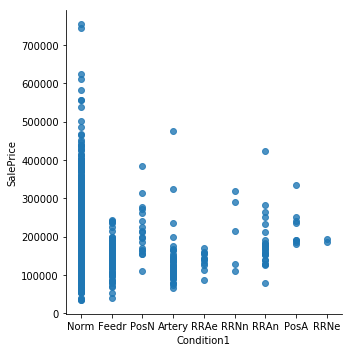

In [18]:
#Kaggle　House Prices　
# -*- coding: utf-8 -*-
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from google.cloud import bigquery

#一時的にwarnings非表示に
import warnings
warnings.filterwarnings('ignore')

#マイライブラリー読込
from mylib import *



#データ読み込みをBigqueryから行うサンプル################################################
#https://cloud.google.com/bigquery/docs/python-client-migration?hl=ja
'''
client = bigquery.Client()

QUERY = (
    'SELECT * FROM `verdant-wares-237302.testdata_set.sample2`'
)

query_job = client.query(
    QUERY,
    # Location must match that of the dataset(s) referenced in the query.
    location='US')  # API request - starts the query

#DataFrame初期化
cols = ['col1', 'col2']
df = pd.DataFrame(index=[], columns=cols)
i = 0
for row in query_job:  # API request - fetches results
    # Row values can be accessed by field name or index
    assert row[0] == row.Name == row['Name']
    df.loc[i] = [row['Name'],row['Age']]
    print(row)
    i+=1

print(df.head())
print("hello")
'''
#BigquerySampleここまで################################################################

# データの読み込み
train =pd.read_csv('gs://sample_machine_learning_input/HousePrices/train.csv')
test = pd.read_csv('gs://sample_machine_learning_input/HousePrices/test.csv')

#求める販売価格が例外的なデータを先に除外
sns.lmplot(x='GrLivArea',y='SalePrice',data=train,fit_reg=False)
#外れているデータを削除
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)


sns.lmplot(x='GrLivArea',y='SalePrice',data=train,fit_reg=False)

sns.lmplot(x='Neighborhood',y='SalePrice',data=train,fit_reg=False)

sns.lmplot(x='Condition1',y='SalePrice',data=train,fit_reg=False)





# データタイプがobjectの列の値をラベル化した数値に変換
for i in range(train.shape[1]):
    if train.iloc[:,i].dtypes == object:
        lbl = LabelEncoder()
        lbl.fit(list(train.iloc[:,i].values) + list(test.iloc[:,i].values))
        train.iloc[:,i] = lbl.transform(list(train.iloc[:,i].values))
        test.iloc[:,i] = lbl.transform(list(test.iloc[:,i].values))

        
# Label Encodeされた後の、SaleConditionカラムにセットされている値の一覧
train["SaleCondition"].unique()

# データ分割
train_ID = train['Id']
test_ID = test['Id']

y_train = train['SalePrice']
X_train = train.drop(['Id','SalePrice'], axis=1)
X_test = test.drop('Id', axis=1)


#欠落データのチェック
pd.set_option('display.max_rows', 500)
print(missingData_check(train,pd,"グラフ"))
print(missingData_check(test,pd,"グラフ"))


#トレーニングデータとテストデータを結合
Xmat = pd.concat([X_train, X_test])
# 欠損が多いカラムを削除
Xmat = Xmat.drop(['LotFrontage','MasVnrArea','GarageYrBlt'], axis=1)
# 欠損値の少ないカラムのNaNは中央値(median)で埋める
Xmat = Xmat.fillna(Xmat.median())

# 対数計算を実施
# 数字のばらつき、偏りを小さくする
y_train = np.log(y_train)

# trainデータとtestデータを含んでいるXmatを、再度trainデータとtestデータに分割
X_train = Xmat.iloc[:train.shape[0],:]
X_test = Xmat.iloc[train.shape[0]:,:]

# 線形回帰(Linear Regression)
slr = LinearRegression()

# fit関数で学習開始
slr.fit(X_train,y_train)

# 偏回帰係数(回帰分析において得られる回帰方程式の各説明変数の係数)を出力
# 偏回帰係数はscikit-learnのcoefで取得
print('傾き：{0}'.format(slr.coef_[0]))

# y切片(直線とy軸との交点)を出力
# 余談：x切片もあり、それは直線とx軸との交点を指す
print('y切片: {0}'.format(slr.intercept_))

print(slr.score(X_train, y_train))

y_test_pred = np.exp(slr.predict(X_test))

submission = pd.DataFrame({
    "Id": test_ID,
    "SalePrice": y_test_pred
})
submission.to_csv('gs://sample_machine_learning_output/HousePrices/hp_submission.csv', index=False)
